# Parse XML

In [1]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from xml.dom import minidom

In [2]:
#Function to parse xml
def parseXML(filename, isInclude):
    abstracts = []
    tags = []
    xmldoc = minidom.parse(filename)
    itemlist = xmldoc.getElementsByTagName('abstract')
    for node in xmldoc.getElementsByTagName('abstract'):
        abstract = node.getElementsByTagName('style')[0].firstChild.nodeValue
        abstracts.append(abstract)
        tags.append(isInclude)  
    return abstracts, tags

In [29]:
abstractsInclude, tagsInclude = parseXML('copperTestInclude.xml', 1)
abstractsExclude, tagsExclude = parseXML('copperTestExclude.xml', 0)
df = pd.DataFrame(list(zip(tagsInclude + tagsExclude, abstractsInclude + abstractsExclude)), 
               columns =['code', 'abstract'])
df.head()

,code,abstract
0,1,OBJECTIVE To determine whether antimicrobial-i...
1,1,Copper surfaces and hospital acquired infectio...
2,0,OBJECTIVE: Determine the rate and outcome of n...
3,0,Human enteric viruses are associated with seve...
4,0,Vancomycin-resistant enterococcus (VRE) is now...


# Load Sci-BERT Model

In [20]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

scibert_model = BertModel.from_pretrained("dmis-lab/biobert-large-cased-v1.1",
                                  output_hidden_states=True)
scibert_tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1")

print('scibert_tokenizer is type:', type(scibert_tokenizer))
print('    scibert_model is type:', type(scibert_model))


scibert_tokenizer is type: <class 'transformers.tokenization_bert.BertTokenizer'>
    scibert_model is type: <class 'transformers.modeling_bert.BertModel'>


# Calculate Embeddings using Sci-BERT

In [22]:
def get_embedding(model, tokenizer, text):

    # Encode with special tokens ([CLS] and [SEP], returning pytorch tensors
    encoded_dict = tokenizer.encode_plus(
                        text,
                        truncation=True,
                        max_length=512,
                        add_special_tokens = True,
                        return_tensors = 'pt'
                )

    input_ids = encoded_dict['input_ids']
    
    # Set model to evaluation mode
    model.eval()
    
    # Run through BERT
    with torch.no_grad():

        outputs = model(input_ids)

        # Extract hidden states
        hidden_states = outputs[2]

    # Select the embeddings
    token_vecs = hidden_states[-2][0]

    # Calculate average of token vectors
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to np array
    sentence_embedding = sentence_embedding.detach().numpy()

    return sentence_embedding

In [30]:
from IPython.display import clear_output
import timeit

embeddings = []
length = len(df['abstract'].tolist())
index = 0

start = timeit.default_timer()
for sentence in df['abstract'].tolist():
    clear_output(wait=True)
    index += 1
    sen_emb = get_embedding(scibert_model, scibert_tokenizer, sentence)
    embeddings.append(sen_emb)

    stop = timeit.default_timer()

    if (index/length*100) < 1:
        expected_time = "Calculating..."

    else:
        time_perc = timeit.default_timer()
        expected_time = np.round( (time_perc-start) /(index/length) /60,2)

    print(index, length)
    print(expected_time)

    
# Append to dataframe
df['scibert'] = embeddings
# Save dataframe to prevent recalculation
df.to_pickle("./copperBiobertTest.pkl")
df.head()

95 95
1.47


,code,abstract,scibert
0,1,OBJECTIVE To determine whether antimicrobial-i...,"[-0.37710634, -0.00848145, -0.06006252, 0.2378..."
1,1,Copper surfaces and hospital acquired infectio...,"[-0.07948789, -0.3335349, -0.2870916, -0.03196..."
2,0,OBJECTIVE: Determine the rate and outcome of n...,"[-0.26771128, -0.09738965, -0.08669737, -0.049..."
3,0,Human enteric viruses are associated with seve...,"[-0.122248754, 0.073618524, -0.1969428, 0.0426..."
4,0,Vancomycin-resistant enterococcus (VRE) is now...,"[-0.25075105, 0.23721822, -0.34318107, 0.07589..."


# Train Model

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

def plotConfMatrix(actual, pred, labels):
    conf_matrix = confusion_matrix(actual, pred)
    labels = ["Exclude", "Include"]
    df_cm = pd.DataFrame(conf_matrix, columns=labels, index=labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (4,2))
    sns.set(font_scale=1.2)#for label size
    sns.heatmap(df_cm, fmt='d', cmap="Blues", annot=True, annot_kws={"size": 12})# font size
    plt.show()

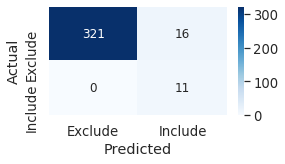

In [28]:
df = pd.read_pickle("./copperBiobertTrain.pkl")
df = df.sample(frac=1)
df.head()

train_data = df['scibert'].tolist()
train_labels = df['code'].tolist()

model = LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000)

model.fit(train_data, train_labels)
pred = model.predict(train_data)

labels = ["Exclude", "Include"]
plotConfMatrix(train_labels, pred, labels)

# Test Model

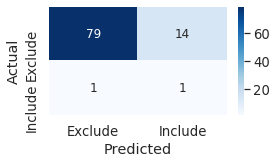

In [31]:
df = pd.read_pickle("./copperBiobertTest.pkl")
df = df.sample(frac=1)
df.head()

test_data = df['scibert'].tolist()
test_labels = df['code'].tolist()

pred = model.predict(test_data)

labels = ["Exclude", "Include"]
plotConfMatrix(test_labels, pred, labels)

# Random Test/Train Split

In [32]:
from sklearn.model_selection import train_test_split

df = pd.concat([pd.read_pickle("./copperTrain.pkl"), pd.read_pickle("./copperTest.pkl")])
df = df.sample(frac=1)

train, test = train_test_split(df, test_size=0.2)

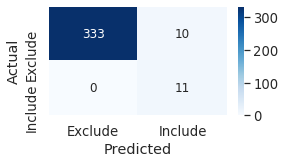

In [33]:
train_data = train['scibert'].tolist()
train_labels = train['code'].tolist()

model = LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000)

model.fit(train_data, train_labels)
pred = model.predict(train_data)

labels = ["Exclude", "Include"]
plotConfMatrix(train_labels, pred, labels)

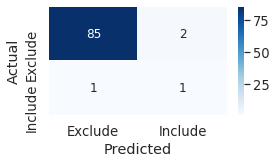

In [34]:
test_data = test['scibert'].tolist()
test_labels = test['code'].tolist()

pred = model.predict(test_data)

labels = ["Exclude", "Include"]
plotConfMatrix(test_labels, pred, labels)

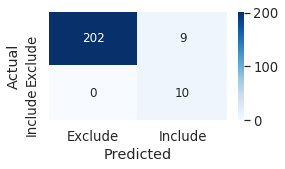

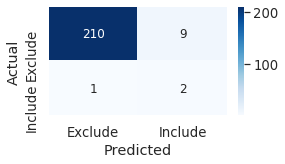

In [19]:
train, test = train_test_split(df, test_size=0.5)

train_data = train['scibert'].tolist()
train_labels = train['code'].tolist()

model = LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000)

model.fit(train_data, train_labels)
pred = model.predict(train_data)

labels = ["Exclude", "Include"]
plotConfMatrix(train_labels, pred, labels)

test_data = test['scibert'].tolist()
test_labels = test['code'].tolist()

pred = model.predict(test_data)

labels = ["Exclude", "Include"]
plotConfMatrix(test_labels, pred, labels)